<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NLTGit/OpenNightLights-colab-mirror/blob/master/onl/tutorials/mod5_4_comparing_cities.ipynb) -->
update colab:

# Random Forest Classifier

Now that we have processed and explored our data, we will try to classify built-up areas with a Random Forest ensemble of decision trees.

Decision tree models are among the most powerful, easy to use, and simple to understand models in the machine learning portfolio. The resources noted in {doc}`mod6_2_supervised_learning_img_classification` are a good place to start. Wikipedia has a comprehensive knowledge base as well if you want to understand general concepts: https://en.wikipedia.org/wiki/Random_forest

More in-depth context on decision tree models and ensemble approaches like Random Forest are out of scope for this tutorial, but worth understanding well if you use them for your analysis, even exploration.

## Training data

Let's recreate the training data "image" for 2015 that fuses Sentinel-2, VIIRS-DNB and GHSL for the Bagmati province.

In [9]:
# import stuff
import geemap, ee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# define some functions and variables
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)


se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

# create training data
roi = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME','Bagmati')).geometry()

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median().select(se2bands).clip(roi)

viirs = ee.Image(ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2019-12-31").filterBounds(roi).median().select('avg_rad').clip(roi))

fused = se2.addBands(viirs)

# create and overlay labels to training data
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    '2015-01-01', '2015-12-31')).select(label).median().gte(2).clip(roi)

points = ghsl.sample(**{"region":roi, "scale":scaleFactor,"seed":0,'geometries':True})

data = fused.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

In [2]:
data.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.18796029458853666,
 'min': 0,
 'sample_sd': 0.39071173874702697,
 'sample_var': 0.15265566279472506,
 'sum': 1174,
 'sum_sq': 1174,
 'total_count': 6246,
 'total_sd': 0.39068046053869543,
 'total_var': 0.15263122224672718,
 'valid_count': 6246,
 'weight_sum': 6246,
 'weighted_sum': 1174}

## Cross-validation

Cross-validation is one of the most important aspects of machine learning development. Last section we talked about several attributes of the training data that may impact classification:
- varying spatial resolution and choices for re-sample rate
- choices about data cleaning
- decisions about which bands to include


We also may decide to create new features (known as feature engineering) by transforming our data sources mathmatically (getting derivatives, information about neighboring pixels, etc) or even fusing additional data.

The classification algorithm itself will have hyperparameters than may be adjusted (known as hyperparameter tuning). 

How do we decide these things? 

Often we will experiment empirically and see what works, this is a big advantage to computing speed and machine learning packages. However, if we just tweak our data until we get the best performance on our training data and leave it at that, we are at serious risk of over-fitting our model (making it too specific to our data on-hand). 

When we try inference on unseen data, it may likely perform terribly, which will impact your analysis and ultimately your stakeholders trust and ability to make informed decisions. This is bad and unfortunately a common challenge to avoid.

That is our situation here: since we dont have any "ground truth" for our data after 2015 in terms of settlements, we will want to validate our classifier as best we can with the labeled data we have before "releasing it to the wild."

### train test split
A key way to do that is to split our labeled data into two components: training and testing sets (or even train, validation and test sets). There are many strategies for this -- and unfortunately things can get quite complex with time series (since observations in time are "dependent" on observations before, we cannot fairly randomly split them). 

For our purposes, a simple 80/20 train/test split randomly among the pixels in our 2015 training image will be fine.

In [3]:
# we'll create a column of random numbers
data = data.randomColumn(seed=0)
split_thresh = 0.8

train = data.filter(ee.Filter.lt('random',split_thresh))
test = data.filter(ee.Filter.gte('random',split_thresh))

In [4]:
train.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.185694361426579,
 'min': 0,
 'sample_sd': 0.3888985722164412,
 'sample_var': 0.15124209947198652,
 'sum': 932,
 'sum_sq': 932,
 'total_count': 5019,
 'total_sd': 0.38885982765124255,
 'total_var': 0.15121196556095406,
 'valid_count': 5019,
 'weight_sum': 5019,
 'weighted_sum': 932}

In [5]:
test.aggregate_stats(label).getInfo()

{'max': 1,
 'mean': 0.19387755102040816,
 'min': 0,
 'sample_sd': 0.3955022859415305,
 'sample_var': 0.15642205818497612,
 'sum': 228,
 'sum_sq': 228,
 'total_count': 1176,
 'total_sd': 0.3953340944451126,
 'total_var': 0.1562890462307372,
 'valid_count': 1176,
 'weight_sum': 1176,
 'weighted_sum': 228}

We have ~5,000 observations (pixels) in our training set and ~1,280 in our test set.

And notice that summary statistics for our label are nearly identical, which we'd expect in a random split.

## Train the classifier

Here we fit the Random Forest estimator to our training data using some initial hyperparameters.

In [6]:
init_params = {"numberOfTrees":100, # the number of individual decision tree models
              "variablesPerSplit":None,  # the number of features to use per split
              "minLeafPopulation":1, # smallest sample size possible per leaf
              "bagFraction":0.5, # fraction of data to include for each individual tree model
              "maxNodes":None, # max number of leafs/nodes per tree
               "seed":0}  # random seed for "random" choices like sampling. Setting this allows others to reproduce your exact results even with stocastic parameters

clf = ee.Classifier.smileRandomForest(**init_params).train(train, label, trainingbands)

## Evaluation

We need metrics to determine how well the classifier performs. We just have a simple binary schema so we can visaulize a confusion matrix, which shows the actual labels (y axis) and the predicted labels (x axis).

In [7]:
trainResults = clf.confusionMatrix().getInfo()
trainCM = pd.DataFrame(np.asarray(trainResults), index=['not','built-up'], columns=['not','built-up'])

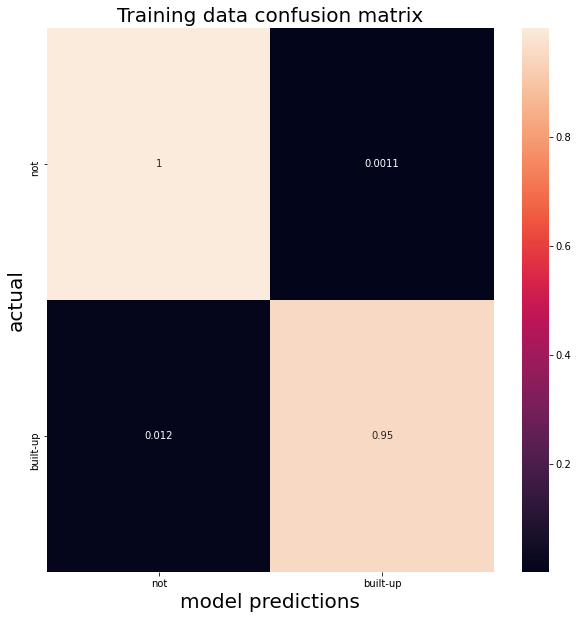

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM/trainCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Training data confusion matrix", fontsize=20);

The matrix shows True Negatives (top left), False Positives (top right), True Positives (bottom right) and False Negatives (bottom left).

Accuracy measures the ratio of hits for both postiive (built up) and negative (not) classes:

$$ACC = \frac{TP + TN}{TP + TN + FP + FN}$$

In [11]:
acc = (trainCM.loc['built-up','built-up'] + trainCM.loc['not','not']) / trainCM.sum().sum()

print(f"Our classifier has an accuracy of {acc:.5f} on the training data.")

Our classifier has an accuracy of 0.99040 on the training data.


With a balanced class (~50% built up and 50% not), this metric might be ok, assuming we didnt care at all about false positives or negatives. 

Consider the extreme example where 1 out of 100 observations are positive. A classifier could predict that everything is negative and be right 99 of 100 times...99% accuracy might be considered good, but there is no predictive power here and no information is yielded. 

Worse, if you do care about false negatives (say, if the test is for a disease or something with high stakes) you do not want a classifier that just predicts negatives naively.

For binary classification, the <a href="https://en.wikipedia.org/wiki/Matthews_correlation_coefficient">Matthews correlation coefficient</a> (based on Pearson's phi coefficient) is a better score:

$$MCC = \frac{TP * TN - FP * FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$$

In [15]:
def get_mcc(cm, pos_label='built-up',neg_label='not'):
    tp = cm.loc[pos_label, pos_label]
    tn = cm.loc[neg_label, neg_label]
    fn = cm.loc[pos_label, neg_label]
    fp = cm.loc[neg_label, pos_label]
    
    return (tp * tn - fp * fn)/(np.sqrt((tp + fp)*(tp + fn) * (tn + fp)* (tn +fn)))

mcc = get_mcc(trainCM)
print(f"Our classifier has an MCC score of {mcc:.5f} on the training data.")

Our classifier has an MCC score of 0.96825 on the training data.


### Test results

Either way, the performance seems good, but remember this is the data we trained the classifier on, so it really just learned about this specific data. We need to look at the out sample that it was not trained on to get a better indication of how this classifier will do on data unseen data.

Our classifier has an accuracy of 0.90179 on the test data.
Our classifier has an MCC score of 0.63031 on the test data.


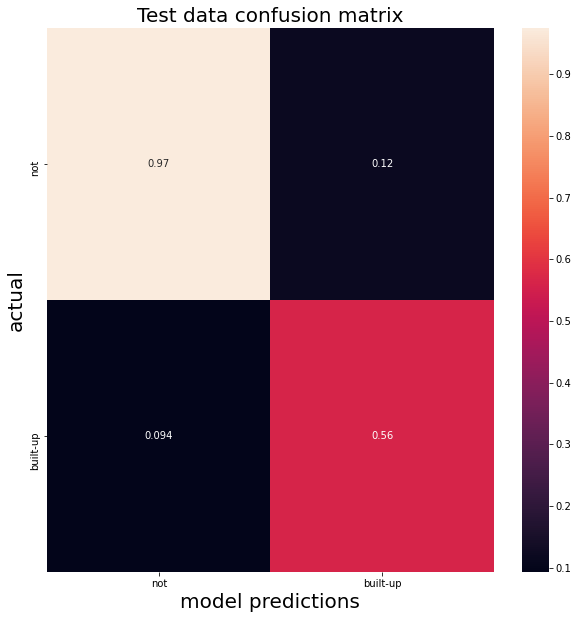

In [17]:
testResults = test.classify(clf).errorMatrix(label, 'classification').getInfo()
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data confusion matrix", fontsize=20);
acc = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
mcc = get_mcc(testCM)
print(f"Our classifier has an accuracy of {acc:.5f} on the test data.")
print(f"Our classifier has an MCC score of {mcc:.5f} on the test data.")

We can see the difference in the confusion matrix and in the lower accuracy -- and far lower MCC scores.

On unseen data, our classifier seems to be over-predicting built up areas.

This might be important for our final analysis...if this over-prediction is based on some bias related to some effect in nighttime lights and our classifier is learning this bias, we might report increased economic growth in error.

Let's see if increasing he number of estimators (trees) in our ensemble improves things on our test data results.

In [19]:
new_params = {"numberOfTrees":500, 
              "variablesPerSplit":None,  
              "minLeafPopulation":1, 
              "bagFraction":0.5, 
              "maxNodes":None, 
               "seed":0}

clf2 = ee.Classifier.smileRandomForest(**new_params).train(train, label, trainingbands)

Our classifier has an accuracy of 0.90049 on the test data.
Our classifier has an MCC score of 0.63850 on the test data.


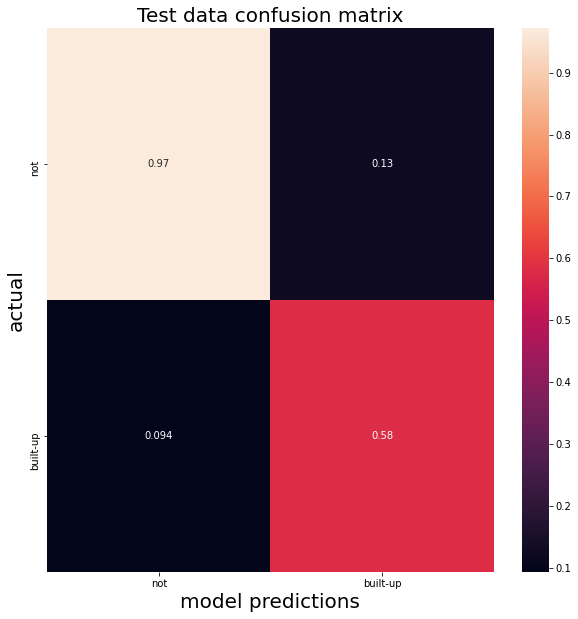

In [21]:
testResults = test.classify(clf2).errorMatrix(label, 'classification').getInfo()
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data confusion matrix", fontsize=20);
acc = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
mcc = get_mcc(testCM)
print(f"Our classifier has an accuracy of {acc:.5f} on the test data.")
print(f"Our classifier has an MCC score of {mcc:.5f} on the test data.")

We see some incremental improvement. If you spend a lot of time with machine learning algorithms, you will see that model tuning at best usually delivers incremental results. But thinking more about the data (feature engineering, additional sources, etc) usually makes bigger improvements.

What happens when we try cleaning the data like we did before?

Our classifier has an accuracy of 0.90191 on the test data.
Our classifier has an MCC score of 0.64406 on the test data.


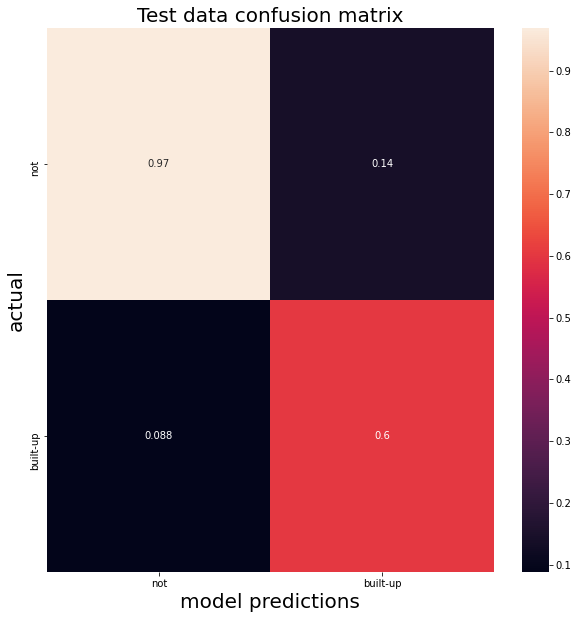

In [40]:
vmu = viirs.reduceRegion(reducer=ee.Reducer.mean(),scale=scaleFactor)
vstd = viirs.reduceRegion(reducer=ee.Reducer.stdDev(),scale=scaleFactor)

vmu = ee.Number(vmu.get('avg_rad'))
vstd = ee.Number(vstd.get('avg_rad'))

viirsclean = viirs.subtract(vmu).divide(vstd)

fusedclean = se2.addBands(viirsclean)

dataclean = fusedclean.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# we'll create a column of random numbers
dataclean = dataclean.randomColumn(seed=0)
split_thresh = 0.8

trainclean = dataclean.filter(ee.Filter.lt('random',split_thresh))
testclean = dataclean.filter(ee.Filter.gte('random',split_thresh))

clf3 = ee.Classifier.smileRandomForest(**new_params).train(trainclean, label, trainingbands)

testResults = testclean.classify(clf3).errorMatrix(label, 'classification').getInfo()
testCM = pd.DataFrame(np.asarray(testResults), index=['not','built-up'], columns=['not','built-up'])

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testCM/testCM.sum(axis=1), annot=True)
ax.set_xlabel('model predictions', fontsize=20)
ax.set_ylabel('actual', fontsize=20)
plt.title("Test data confusion matrix", fontsize=20);
acc = (testCM.loc['built-up','built-up'] + testCM.loc['not','not']) / testCM.sum().sum()
mcc = get_mcc(testCM)
print(f"Our classifier has an accuracy of {acc:.5f} on the test data.")
print(f"Our classifier has an MCC score of {mcc:.5f} on the test data.")

In a real scenario, you would spend a lot of time in this phase of research trying to validate your model. You should also look to independent sources of economic growth. We'll move on for now, but think about some ways you might improve this model using the data we have (or exploring other data!).

## Visualize prediction

Applying that last trained classifier on our entire image, we can visualize the predicted land cover.

In [46]:
result = fused.select(trainingbands).classify(clf3)

In [47]:
ghslVis= {"palette":['000000', 'ffffff']}
se2Vis = {"min":0.0, "max":0.3,"bands": ['B4','B3','B2']}

# initialize our map
map1 = geemap.Map()
map1.centerObject(roi, 9)
map1.addLayer(se2, se2Vis, "S2")
map1.addLayer(viirsclean, {}, "VIIRS-DNB")
map1.addLayer(ghsl, ghslVis, "GHSL")
map1.addLayer(result.randomVisualizer(), {}, 'classified')
map1.addLayerControl()
map1

Map(center=[27.87388743003947, 85.41973735675019], controls=(WidgetControl(options=['position'], widget=HBox(c…

We have some odd truncated edges likely due to the re-sampling process. Worth investigating further, but at at glance we can see the built up area (green) that appears quite close to what we would expect given the GHSL data